# LSTM Model

In [1]:
import pandas as pd 
from sklearn.model_selection  import train_test_split
import numpy as np 
import matplotlib.pyplot as plt
from pandas import DataFrame
from sklearn.metrics import mean_squared_error
from math import sqrt
from pandas.plotting import lag_plot
from sklearn import metrics
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import StandardScaler

2023-02-28 09:30:00.972158: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-28 09:30:01.737509: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-28 09:30:01.737544: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-02-28 09:30:03.423976: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

# Load and PreProcess 

In [2]:
data = pd.read_csv('data/PMS_data.csv',nrows=100000)

In [3]:
data.head()

,Flow,Occupy,Speed
0,133.0,0.0603,65.8
1,210.0,0.0589,69.6
2,124.0,0.0358,65.8
3,145.0,0.0416,69.6
4,206.0,0.0493,69.4


In [4]:
new_set = data[['Flow','Occupy']].copy()
new_set['Flow'] = np.around(new_set['Flow'])
new_set.head()

,Flow,Occupy
0,133.0,0.0603
1,210.0,0.0589
2,124.0,0.0358
3,145.0,0.0416
4,206.0,0.0493


# 1 features

In [7]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler

# Load the data
data = new_set[["Flow"]]
#data = data[['traffic_volume']]

# Normalize the data
scaler = MinMaxScaler()
data = scaler.fit_transform(data)

# Split the data into training and testing sets
train_size = int(len(data) * 0.8)
test_size = len(data) - train_size
train_data, test_data = data[0:train_size,:], data[train_size:len(data),:]

# Create sequences of data
def create_sequences(data, seq_length):
    x = []
    y = []
    for i in range(len(data)-seq_length-1):
        x.append(data[i:(i+seq_length), 0])
        y.append(data[i+seq_length, 0])
    return np.array(x), np.array(y)

seq_length = 30
trainX, trainY = create_sequences(train_data, seq_length)
testX, testY = create_sequences(test_data, seq_length)

# Reshape the data for the LSTM model
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

# Define the model architecture
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(64, input_shape=(seq_length, 1),return_sequences=True, unit_forget_bias=True),
    tf.keras.layers.LSTM(32,return_sequences=True),
    tf.keras.layers.LSTM(64,return_sequences=False),
    tf.keras.layers.Dense(1)
])


In [ ]:

# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam')

# Train the model
history = model.fit(trainX, trainY, epochs=20, batch_size=64, validation_data=(testX, testY))

# Make predictions on the test data
testPredict = model.predict(testX)

# Inverse transform the predictions and actual values
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

# Calculate root mean squared error
rmse = np.sqrt(np.mean((testPredict - testY) ** 2))
print('Test RMSE: %.2f' % rmse)

In [10]:
testYshape=testY.reshape(19969,1)
print(testY.shape)
print(testYshape.shape)
print(testPredict.shape)
r2s = metrics.r2_score(y_true=testYshape,y_pred=testPredict)
r2s

(1, 19969)
(19969, 1)
(19969, 1)


0.7075555063659578

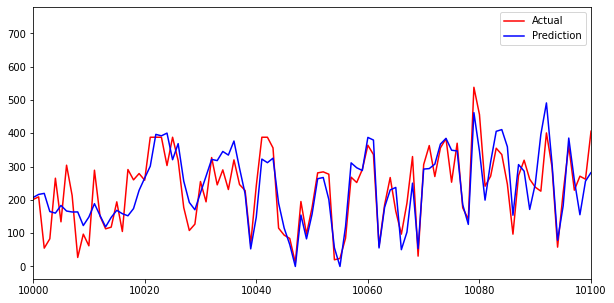

In [11]:
plt.figure(figsize=(10,5))
plt.plot(testYshape,color = 'red',label = 'Actual')
plt.plot(testPredict,color = 'blue',label = 'Prediction')
plt.legend()
plt.xlim(10000,10100)
plt.show()

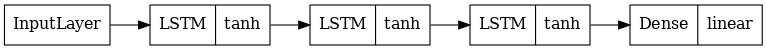

In [10]:
from keras.utils import plot_model
plot_model(model, to_file='model.png',
    show_shapes=False,
    show_dtype=False,
    show_layer_names=False,
    rankdir='LR',
    expand_nested=True,
    dpi=80,
    layer_range=None,
    show_layer_activations=True)

# 2 features

In [ ]:
import numpy as np
import pandas as pd
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Load the data
data = pd.read_csv('data/PMS_data.csv',nrows=100000)

# Extract the features you want to use
data = data[['Flow', 'Occupy']]

# Normalize the data
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

# Split the data into training and testing sets
train_size = int(len(data_scaled) * 0.8)
train_data, test_data = data_scaled[0:train_size], data_scaled[train_size:]
print(train_data.shape[1])

def create_sequences(data, seq_length):
    x = []
    y = []
    for i in range(len(data)-seq_length-1):
        # Extract two features (traffic volume and temperature)
        feature1 = data[i:(i+seq_length), 0]
        feature2 = data[i:(i+seq_length), 1]
        x.append(np.column_stack((feature1, feature2)))
        y.append(data[i+seq_length, 0])
    return np.array(x), np.array(y)
seq_length = 30
trainX, trainY = create_sequences(train_data, seq_length)
testX, testY = create_sequences(test_data, seq_length)

# Define the LSTM model
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(50, input_shape=(trainX.shape[1], trainX.shape[2])),
    tf.keras.layers.Dense(1)
])

# Compile the model
model.compile(loss='mse', optimizer='adam')

# Fit the model
history = model.fit(trainX, trainY, epochs=50, batch_size=72, validation_data=(testX, testY), verbose=2, shuffle=False)
